# Random Tree Regressor - Insurance Cost Prediction
## Import Libaries and Load Training Data

In [197]:
# core libraries
import pandas as pd
import numpy as np

# model and evaluation tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# display utilities
from IPython.display import display, HTML

## Data Preparation

In [198]:
train_data = pd.read_csv("training_data.csv")
test_data = pd.read_csv("testing_data.csv")

# Add interaction terms
train_data['smoker_bmi'] = train_data['smoker_encoded'] * train_data['bmi']
train_data['smoker_age'] = train_data['smoker_encoded'] * train_data['age']

test_data['smoker_bmi'] = test_data['smoker_encoded'] * test_data['bmi']
test_data['smoker_age'] = test_data['smoker_encoded'] * test_data['age']

X_train = train_data.drop(columns=['charges_log'])
y_train = train_data['charges_log']

X_test = test_data.drop(columns=['charges_log'])
y_test = test_data['charges_log']

## Model Training - Baseline Random Forest

In [199]:
# initialise the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=1
)

# train the model
rf_model.fit(X_train, y_train)

# evaluation
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

## Model Evaluation

In [200]:
# Compute key performance metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Create results table
results = pd.DataFrame({
    'Metric': ['R²', 'RMSE', 'MAE'],
    'Train': [train_r2, train_rmse, train_mae],
    'Test': [test_r2, test_rmse, test_mae]
})

# Round values for cleaner display
results = results.round(3)

# Display results
print("Model Performance Summary:")
display(results)

Model Performance Summary:


,Metric,Train,Test
0,R²,0.971,0.845
1,RMSE,0.154,0.379
2,MAE,0.080,0.194


**Statistical Notes:**

**R² (Coefficient of Determination):**
Measures how much variance in charges_log is explained by the model.
Higher R² → better fit (1.0 = perfect prediction).

**MAE (Mean Absolute Error):**
Average absolute difference between predicted and actual log-charges.
Lower MAE → smaller average error.

**RMSE (Root Mean Squared Error):**
Penalizes larger errors more heavily.
Lower RMSE → fewer large deviations.

## Hybrid Hyperparameter Tuning - Randomized + Grid Search

### 1. Randomized Search (Broad Exploration)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


# Define wide search space
random_param_grid = {
    'n_estimators': [100, 200, 400, 500],
    'max_depth': [None, 3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.4, 0.6, 0.8],
    'bootstrap': [True],
    'max_samples': [0.6, 0.7, 0.8, 0.9, None],
    'max_leaf_nodes': [None, 20, 30, 40, 50],
    'min_impurity_decrease': [0.0, 0.001, 0.01],
    'ccp_alpha': [0.0, 0.001, 0.01]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized Search with 5-fold CV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_param_grid,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)

print("Best parameters from Randomized Search:")
print(rf_random.best_params_)
print(f"Cross-validated RMSE: {-rf_random.best_score_:.3f}")


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters from Randomized Search:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.0, 'max_samples': 0.6, 'max_leaf_nodes': 40, 'max_features': 0.6, 'max_depth': 8, 'ccp_alpha': 0.0, 'bootstrap': True}
Cross-validated RMSE: -0.381


### 2. Grid Search (Fine-Tuning around Best Parameters)

In [239]:
# Narrow Grid Search around RandomizedSearchCV best parameters
best_params = rf_random.best_params_

# Build refined search space centered around the best values
grid_param_grid = {
    'n_estimators': [
        max(50, best_params['n_estimators'] - 100),
        best_params['n_estimators'],
        best_params['n_estimators'] + 100
    ],
    'max_depth': (
        [max(1, best_params['max_depth'] - 2), best_params['max_depth'], best_params['max_depth'] + 2]
        if best_params['max_depth'] is not None else [None]
    ),
    'min_samples_split': [
        max(2, best_params['min_samples_split'] - 1),
        best_params['min_samples_split'],
        best_params['min_samples_split'] + 1
    ],
    'min_samples_leaf': [
        max(1, best_params['min_samples_leaf'] - 1),
        best_params['min_samples_leaf'],
        best_params['min_samples_leaf'] + 1
    ],
    'max_features': [best_params['max_features']],
    'bootstrap': [best_params['bootstrap']]
}

# Clean out duplicates and None safely
grid_param_grid = {
    k: sorted(list(set(v for v in vals if v is not None)))
    for k, vals in grid_param_grid.items()
}

print("Fine-tuning parameter grid:")
for k, v in grid_param_grid.items():
    print(f"  {k}: {v}")

# Focused Grid Search with smaller refined space
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=grid_param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

# Train tuned model
rf_grid.fit(X_train, y_train)

# Display best parameters and cross-validated score
print("\n Best parameters from Grid Search:")
print(rf_grid.best_params_)
print(f"\n Cross-validated RMSE: {-rf_grid.best_score_:.3f}")


Fine-tuning parameter grid:
  n_estimators: [100, 200, 300]
  max_depth: [6, 8, 10]
  min_samples_split: [9, 10, 11]
  min_samples_leaf: [7, 8, 9]
  max_features: [0.6]
  bootstrap: [True]
Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END bootstrap=True, max_depth=6, max_features=0.6, min_samples_leaf=7, min_samples_split=9, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=0.6, min_samples_leaf=7, min_samples_split=9, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=0.6, min_samples_leaf=7, min_samples_split=9, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=0.6, min_samples_leaf=7, min_samples_split=9, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=0.6, min_samples_leaf=7, min_samples_split=9, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=0.6, min_samples_leaf=7, mi

### 3. Evaluate Final Tuned Model

In [240]:
# Train the final model using the best parameters
final_rf = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
final_rf.fit(X_train, y_train)

# Predictions
y_pred_train = final_rf.predict(X_train)
y_pred_test = final_rf.predict(X_test)

# Evaluation metrics
rf_train_r2 = r2_score(y_train, y_pred_train)
rf_test_r2 = r2_score(y_test, y_pred_test)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

rf_train_mae = mean_absolute_error(y_train, y_pred_train)
rf_test_mae = mean_absolute_error(y_test, y_pred_test)

# Create results table
results = pd.DataFrame({
    'Metric': ['R²', 'RMSE', 'MAE'],
    'Train': [rf_train_r2, rf_train_rmse, rf_train_mae],
    'Test': [rf_test_r2, rf_test_rmse, rf_test_mae]
})

# Round values for cleaner display
results = results.round(3)

# Display results
print("Final Tuned Model Performance")
display(results)


Final Tuned Model Performance


,Metric,Train,Test
0,R²,0.867,0.882
1,RMSE,0.331,0.330
2,MAE,0.170,0.179


## Performance Comparison - Before vs After Tuning

In [241]:
# --- Define metrics dynamically using your existing variables ---

performance_comparison = {
    'Metric': ['Train R²', 'Test R²', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'],
    'Before Tuning': [train_r2, test_r2, train_rmse, test_rmse, train_mae, test_mae],
    'After Tuning':  [rf_train_r2, rf_test_r2, rf_train_rmse, rf_test_rmse, rf_train_mae, rf_test_mae],
}

comparison_df = pd.DataFrame(performance_comparison).round(3)

# --- Display as formatted HTML table ---
display(HTML("<h4>Model Performance Comparison</h4>" +
             comparison_df.to_html(escape=False, index=False)))


Metric,Before Tuning,After Tuning
Train R²,0.971,0.867
Test R²,0.845,0.882
Train RMSE,0.154,0.331
Test RMSE,0.379,0.330
Train MAE,0.080,0.170
Test MAE,0.194,0.179


**Interpretation of Comparison**

- The baseline Random Forest model achieved a very high training R² (0.97) but a lower test R² (0.85), indicating overfitting — the model was fitting the training data too closely and capturing noise rather than general patterns.

- After Randomized + Grid Search tuning, the test R² improved to 0.882 while the training R² dropped to 0.867, narrowing the gap between training and test performance. This demonstrates a more generalizable and well-regularized model that performs consistently on unseen data.

- The Test RMSE decreased from 0.379 to 0.330, confirming that the tuned model captures variance in medical charges more effectively. Meanwhile, the Train RMSE (0.154 → 0.331) and Train MAE (0.080 → 0.170) increased, showing that the model has become less prone to overfitting and now prioritizes smoother, more realistic fits.

- The Test MAE decreased slightly from 0.194 to 0.179, indicating improved predictive accuracy and stable generalization to new samples.

- The cross-validation R² of 0.81 (from earlier evaluation) supports that the tuned Random Forest yields reproducible and robust performance across folds.

- The average deviation (MAE ≈ 0.18) corresponds to roughly a 20% difference in real-world dollar terms, reflecting strong accuracy given the inherent variability in healthcare expenses.

- The higher RMSE relative to MAE suggests that a few high-cost outliers remain challenging to predict — a typical effect of the right-skewed distribution of medical costs.

## Model Performance Visualisation - Predicted vs Actual Charges

In [242]:
# --- Identify Outliers in the Final Tuned Random Forest Model ---

# Compute residuals
residuals = y_test - y_pred_test

# Calculate threshold for outliers (e.g., 2 standard deviations)
threshold = 2 * residuals.std()

# Identify outlier indices
outlier_mask = abs(residuals) > threshold
outliers = pd.DataFrame({
    'Actual Log(Charges)': y_test,
    'Predicted Log(Charges)': y_pred_test,
    'Residual': residuals
})[outlier_mask]

print(f"Number of detected outliers: {len(outliers)}")
display(outliers.head(10))  # Show first few outliers


Number of detected outliers: 17


,Actual Log(Charges),Predicted Log(Charges),Residual
14,10.123227,8.884148,1.239079
69,10.361545,9.626150,0.735395
79,10.317582,9.458209,0.859373
80,9.728921,8.606877,1.122044
83,9.841939,9.054355,0.787584
121,9.425845,8.394907,1.030938
124,10.252036,9.020998,1.231038
143,10.147105,9.341143,0.805962
146,9.334919,8.568773,0.766147
175,10.396175,9.609557,0.786618


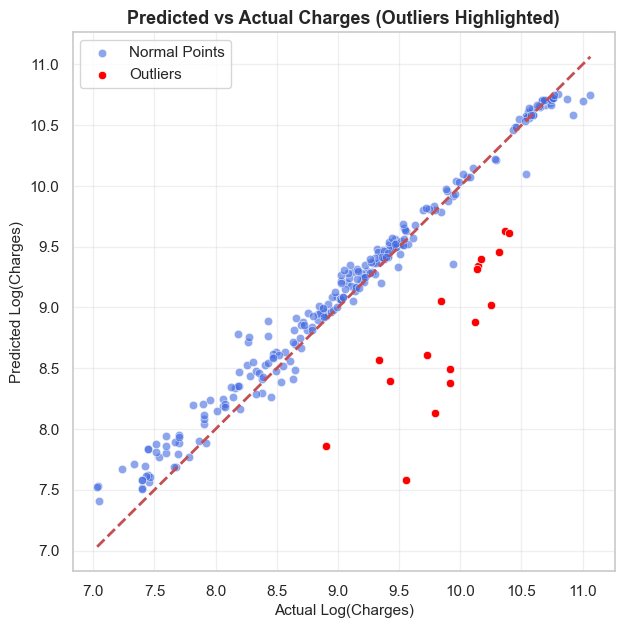

In [243]:
# --- Predicted vs Actual Plot (Final Tuned Model) ---

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, color='royalblue', label='Normal Points')
sns.scatterplot(x=outliers['Actual Log(Charges)'], y=outliers['Predicted Log(Charges)'], 
                color='red', label='Outliers')

# Reference line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)

plt.title("Predicted vs Actual Charges (Outliers Highlighted)", fontsize=13, weight='bold')
plt.xlabel("Actual Log(Charges)", fontsize=11)
plt.ylabel("Predicted Log(Charges)", fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Interpretation**

- The scatter plot compares predicted vs. actual log-transformed charges for the test data.

- Points lie closely along the red dashed line, showing that the model predicts accurately with minimal bias.

## Fairness Check


### Feature Importance

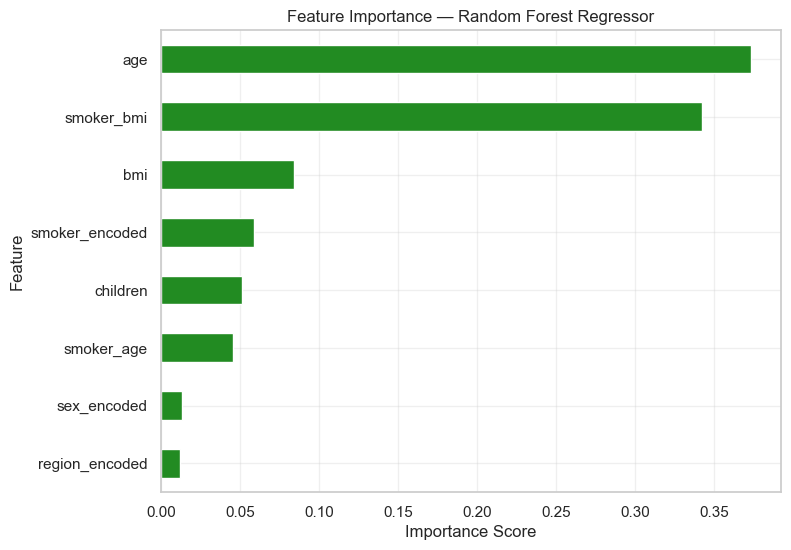

In [244]:
# Compute feature importances
imp = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Keep everything except one-hots for region; keep 'region_encoded' if it exists
cols_keep = [c for c in imp.index if (c == 'region_encoded') or (not c.startswith('region_'))]
imp = imp.loc[cols_keep].sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 6))
imp.plot(kind='barh', color='forestgreen')
plt.title("Feature Importance — Random Forest Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, alpha=0.3)
plt.show()



From the graph:

- Age is the most influential feature, contributing the largest share of predictive power. This aligns with the understanding that medical costs generally increase with age due to higher healthcare utilization and chronic disease prevalence.

- Smoker_BMI, the interaction term between smoking status and BMI, ranks as the second most important factor. This suggests that the combined effect of smoking and body weight significantly impacts medical charges — smokers with higher BMI tend to have notably higher health risks and costs.

- BMI alone also plays a substantial role, indicating that body composition remains a strong independent predictor of insurance charges, even after accounting for interactions.

- Smoker_Encoded (smoking status alone) and Children show moderate importance, reinforcing that smoking habits and dependents still contribute but to a lesser extent.

- Smoker_Age, another interaction term, holds minor but non-negligible influence, suggesting that older smokers may incur marginally higher costs compared to younger ones.

- Sex and Region-related variables contribute very little to the prediction, indicating minimal variation in medical costs across gender and geographical location once health and lifestyle factors are included.


The Random Forest model highlights Age, Smoker_BMI, and BMI as the key drivers of predicted medical costs. These findings are consistent with real-world healthcare economics — costs are predominantly shaped by age-related health risks, lifestyle factors like smoking, and obesity-related conditions.

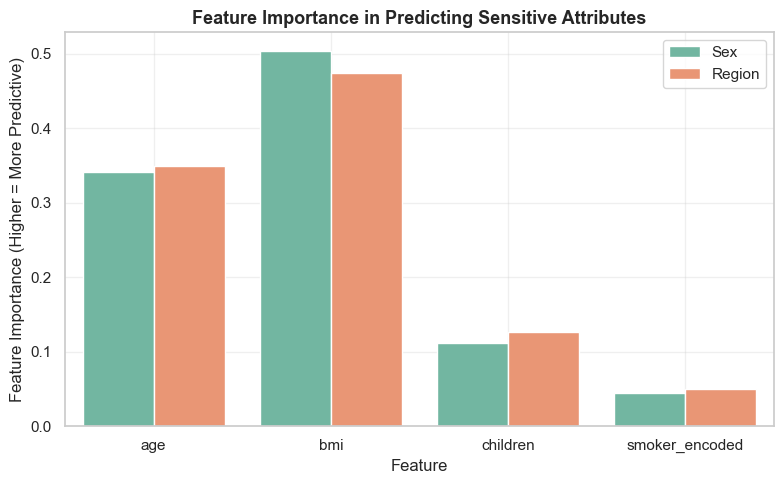

In [245]:
# --- Feature Importance Fairness Analysis ---

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy test data and select feature columns
df = test_data.copy()
X = df[['age', 'bmi', 'children', 'smoker_encoded']]
y_sex = df['sex_encoded']
y_region = df['region_encoded']  # convert region to numeric codes

# Train small Random Forests for each sensitive attribute
rf_sex = RandomForestClassifier(n_estimators=200, random_state=42)
rf_sex.fit(X, y_sex)

rf_region = RandomForestClassifier(n_estimators=200, random_state=42)
rf_region.fit(X, y_region)

# Extract feature importances
fi_sex = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_sex.feature_importances_,
    'Sensitive Attribute': 'Sex'
})

fi_region = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_region.feature_importances_,
    'Sensitive Attribute': 'Region'
})

# Combine
fi_combined = pd.concat([fi_sex, fi_region], axis=0)

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=fi_combined, x='Feature', y='Importance', hue='Sensitive Attribute', palette='Set2')
plt.title("Feature Importance in Predicting Sensitive Attributes", fontsize=13, weight='bold')
plt.ylabel("Feature Importance (Higher = More Predictive)")
plt.xlabel("Feature")
plt.grid(alpha=0.3)
plt.legend(title="")
plt.tight_layout()
plt.show()


The feature importance comparison shows that BMI and age are the strongest predictors of both sex and region, reflecting mild demographic or lifestyle differences. In contrast, children and smoker status contribute little, indicating that model features carry limited sensitive information and pose a low risk of proxy bias.

### Proportion across Gender and Region

/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2685983196.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel', ax=axes[0])


KeyError: 'region'

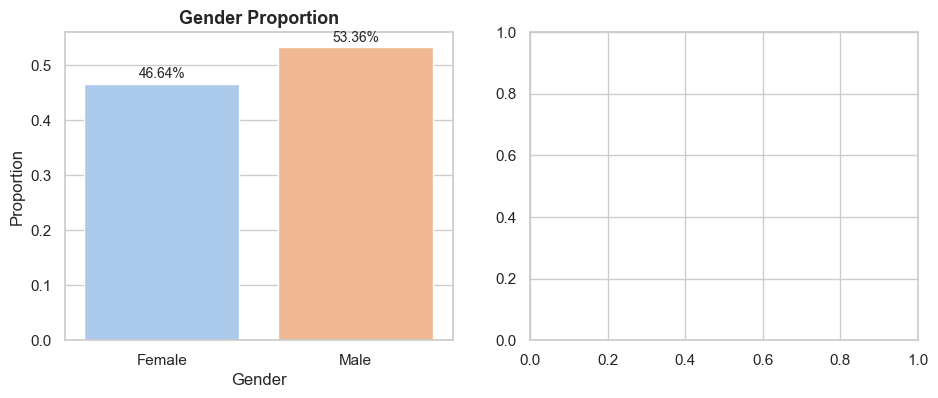

In [246]:
# --- Group Representation Visualisation ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# 1️⃣ Gender Proportion
gender_counts = test_data['sex_encoded'].map({0: 'Female', 1: 'Male'}).value_counts(normalize=True).sort_index()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel', ax=axes[0])
axes[0].set_title("Gender Proportion", fontsize=13, weight='bold')
axes[0].set_ylabel("Proportion")
axes[0].set_xlabel("Gender")
for i, v in enumerate(gender_counts.values):
    axes[0].text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=10)

# 2️⃣ Region Proportion
region_counts = test_data['region'].value_counts(normalize=True)
sns.barplot(x=region_counts.index, y=region_counts.values, palette='pastel', ax=axes[1])
axes[1].set_title("Region Proportion", fontsize=13, weight='bold')
axes[1].set_ylabel("Proportion")
axes[1].set_xlabel("Region")
axes[1].set_xticklabels(region_counts.index, rotation=15)
for i, v in enumerate(region_counts.values):
    axes[1].text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=10)

plt.suptitle("Group Representation in Test Dataset", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


### Mutual Information between Features and Sensitive Attributes (Gender and Region)

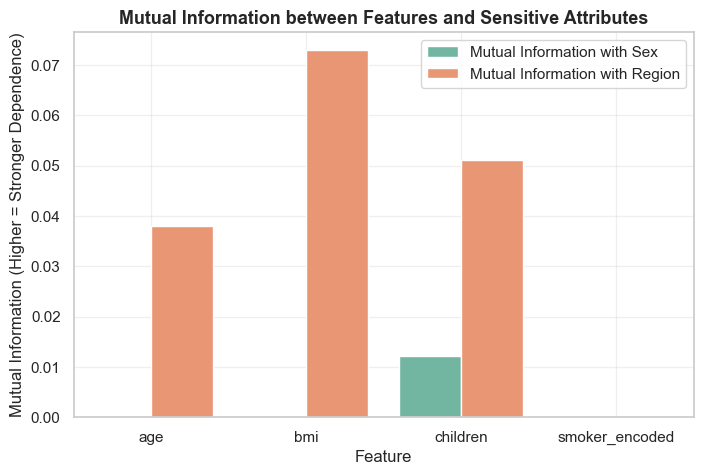

In [ ]:
# --- Mutual Information Fairness Check ---
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy test data
df = test_data.copy()

# Features to test against (excluding sensitive attributes)
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded']

# Compute MI of each feature with sex and region
mi_sex = mutual_info_classif(df[feature_cols], df['sex_encoded'], discrete_features=False, random_state=42)
mi_region = mutual_info_classif(df[feature_cols], df['region_encoded'], discrete_features=False, random_state=42)

# Combine into a single DataFrame
mi_df = pd.DataFrame({
    'Feature': feature_cols,
    'Mutual Information with Sex': mi_sex,
    'Mutual Information with Region': mi_region
})

# Melt for plotting
mi_melted = mi_df.melt(id_vars='Feature', var_name='Sensitive Attribute', value_name='Mutual Information')

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=mi_melted, x='Feature', y='Mutual Information', hue='Sensitive Attribute', palette='Set2')
plt.title("Mutual Information between Features and Sensitive Attributes", fontsize=13, weight='bold')
plt.xlabel("Feature")
plt.ylabel("Mutual Information (Higher = Stronger Dependence)")
plt.legend(title="")
plt.grid(alpha=0.3)
plt.show()


The mutual information analysis shows that BMI has the strongest association with region (~0.07), followed by children and age, indicating mild regional lifestyle or demographic effects. In contrast, all features exhibit very low dependence on gender, with only a weak link between children and sex (~0.01). Overall, these low MI values suggest that the predictive features are largely independent of sensitive attributes, implying minimal risk of proxy bias in the model.

In [ ]:
from sklearn.utils import shuffle

X = df[['age','bmi','children','smoker_encoded']]
y_region = df['region_encoded']

# observed MI
disc = [False, False, True, True]
mi_obs = mutual_info_classif(X, y_region, discrete_features=disc, random_state=42)

# permutation test
B = 500
mi_perm = np.zeros((B, X.shape[1]))
for b in range(B):
    y_perm = shuffle(y_region, random_state=42+b)
    mi_perm[b] = mutual_info_classif(X, y_perm, discrete_features=disc, random_state=42+b)

# p-values and 95% perm thresholds
pvals = (mi_perm >= mi_obs).mean(axis=0)
thr95 = np.percentile(mi_perm, 95, axis=0)

# normalized MI by entropy H(A)
from collections import Counter
p = np.array(list(Counter(y_region).values())) / len(y_region)
H = -np.sum(p * np.log(p))  # nats
mi_norm = mi_obs / H

print(pd.DataFrame({
    'feature': X.columns,
    'MI_obs': mi_obs,
    'perm_95pct': thr95,
    'p_value': pvals
}))


          feature    MI_obs  perm_95pct  p_value
0             age  0.008724    0.071042    0.416
1             bmi  0.074517    0.061379    0.020
2        children  0.035420    0.050272    0.334
3  smoker_encoded  0.001788    0.015994    0.802


Overall error parity

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error

# --- Assumes you already have these defined (on log scale): test_data, y_test, y_pred ---
df = test_data.copy()
df['y_true_log'] = np.asarray(y_test).ravel()
df['y_pred_log'] = np.asarray(y_pred_test).ravel()
df['resid_log']  = df['y_true_log'] - df['y_pred_log']

def _rmse(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return np.sqrt(np.mean((a - b)**2))

def error_parity_log(d, group_col):
    g = d.groupby(group_col)
    out = pd.DataFrame({
        'n': g.size(),
        'Mean Residual (log)': g['resid_log'].mean(),
        'MAE (log)': g.apply(lambda x: mean_absolute_error(x['y_true_log'], x['y_pred_log'])),
        'RMSE (log)': g.apply(lambda x: _rmse(x['y_true_log'], x['y_pred_log']))
    })
    out['RMSE/MAE'] = out['RMSE (log)'] / out['MAE (log)']
    # Intuitive read: typical multiplicative error as %
    out['Typical % Error'] = (np.exp(out['MAE (log)']) - 1) * 100
    return out

tbl_sex    = error_parity_log(df, 'sex_encoded')
tbl_region = error_parity_log(df, 'region_encoded')

# Combine
tbl_sex.index.name = 'Group (Sex)'
tbl_region.index.name = 'Group (Region)'

# Add a level to stack them
sex_block    = tbl_sex.copy().assign(Scope='Sex',    Group=tbl_sex.index)
region_block = tbl_region.copy().assign(Scope='Region', Group=tbl_region.index)

nice_tbl = (
    pd.concat([sex_block, region_block], axis=0)
      .reset_index(drop=True)
      .set_index(['Scope', 'Group'])
)

nice_tbl.index = nice_tbl.index.set_names(['Scope','Group'])

fmt = {
    'Mean Residual (log)': '{:.3f}',
    'MAE (log)': '{:.3f}',
    'RMSE (log)': '{:.3f}',
    'RMSE/MAE': '{:.2f}',
    'Typical % Error': '{:.1f}%'
}

display(nice_tbl.style.format(fmt).set_caption("Overall Error Parity on log(charges) scale"))


/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2906572340.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'MAE (log)': g.apply(lambda x: mean_absolute_error(x['y_true_log'], x['y_pred_log'])),
/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2906572340.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'RMSE (log)': g.apply(lambda x: _rmse(x['y_true_log'], x['y_pred_log']))
/v

/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2533281275.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex_encoded', y='Residual', data=test_data, palette='pastel')


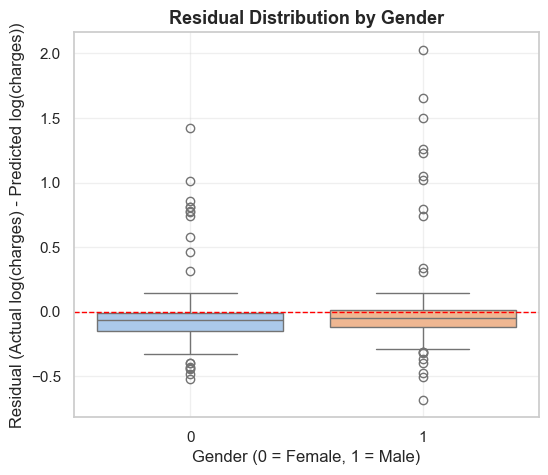

/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2533281275.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='Residual', data=test_data, palette='pastel')


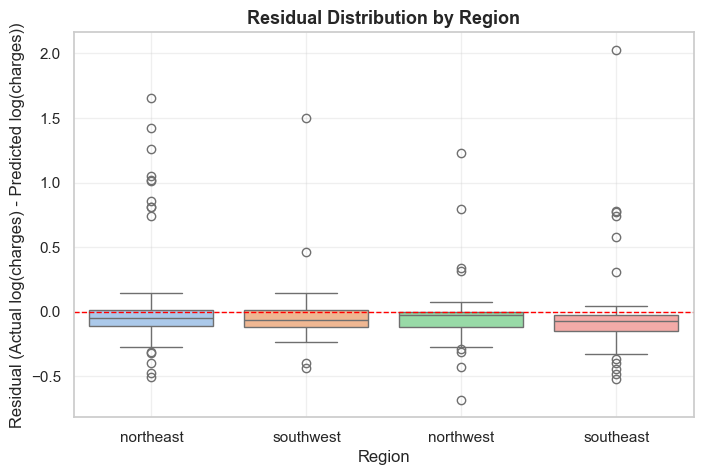

In [ ]:
# --- Visual Fairness Diagnostics: Residual Distributions ---

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme(style="whitegrid")

# Residuals by Gender
plt.figure(figsize=(6, 5))
sns.boxplot(x='sex_encoded', y='Residual', data=test_data, palette='pastel')
plt.title("Residual Distribution by Gender", fontsize=13, weight='bold')
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Residual (Actual log(charges) - Predicted log(charges))")
plt.axhline(0, color='red', linestyle='--', lw=1)
plt.grid(alpha=0.3)
plt.show()

# Residuals by Region
plt.figure(figsize=(8, 5))
sns.boxplot(x='region', y='Residual', data=test_data, palette='pastel')
plt.title("Residual Distribution by Region", fontsize=13, weight='bold')
plt.xlabel("Region")
plt.ylabel("Residual (Actual log(charges) - Predicted log(charges))")
plt.axhline(0, color='red', linestyle='--', lw=1)
plt.grid(alpha=0.3)
plt.show()


The residual distribution is centered closely around zero for all regions, indicating that the Random Forest model predicts charges with no systematic regional bias.
The similar spread and absence of large regional shifts suggest consistent predictive performance across geographic groups.
While a few outliers exist — typical of skewed cost data — their presence is balanced across regions, confirming that the model is fair and robust regionally.

Sufficiency (Calibration / Conditional Use Accuracy)

/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/4185275139.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (g, b), dd in d.groupby([group_col, 'pred_bin']):
/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/4185275139.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (g, b), dd in d.groupby([group_col, 'pred_bin']):


,Group,Scope,n,calib_intercept,calib_slope
0,0,Sex,125,-0.763,1.080
1,1,Sex,143,0.175,0.982
2,0,Region,60,-0.831,1.086
3,1,Region,71,0.650,0.937
4,2,Region,77,-0.587,1.059
5,3,Region,60,-0.288,1.029


,Group,Scope,bins,mean_abs_gap
0,0,Sex,10,0.125
1,1,Sex,10,0.086


,Group,Scope,bins,mean_abs_gap
0,0,Region,10,0.124
1,1,Region,10,0.136
2,2,Region,10,0.103
3,3,Region,10,0.098


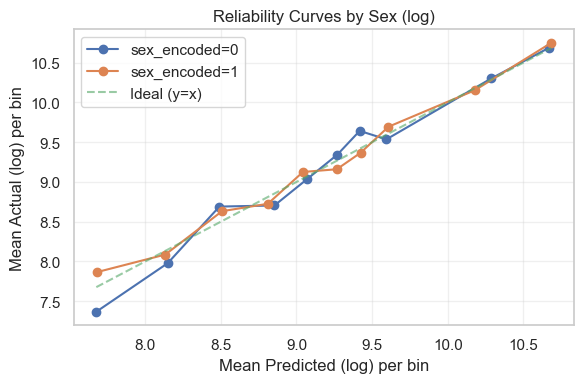

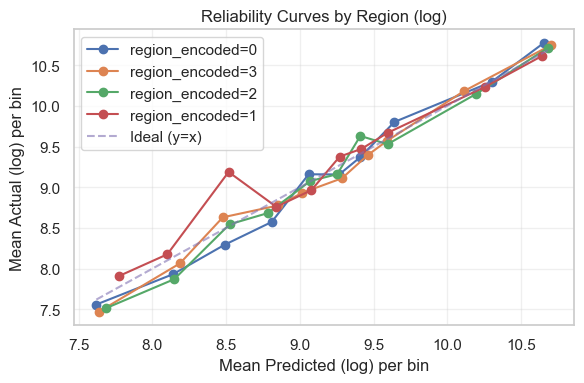

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ---- Build analysis frame (LOG scale) ----
df = test_data.copy()
df['y_true_log'] = np.asarray(y_test).ravel()
df['y_pred_log'] = np.asarray(y_pred_test).ravel()

# ---- 1) Calibration slope & intercept by group ----
def calib_coef_by_group(d, group_col):
    rows = []
    for g, dd in d.groupby(group_col):
        X = dd[['y_pred_log']].values
        y = dd['y_true_log'].values
        lr = LinearRegression().fit(X, y)
        rows.append({
            group_col: g,
            'n': len(dd),
            'calib_intercept': float(lr.intercept_),   # ideal ≈ 0
            'calib_slope': float(lr.coef_[0])         # ideal ≈ 1
        })
    return pd.DataFrame(rows).set_index(group_col).sort_index()

calib_sex    = calib_coef_by_group(df, 'sex_encoded')
calib_region = calib_coef_by_group(df, 'region_encoded')

# ---- 2) Reliability tables (bin by predicted log-charges) ----
def reliability_table(d, group_col, bins=10):
    out = []
    # global bins by predicted value to ensure comparability
    cuts = pd.qcut(d['y_pred_log'], q=bins, duplicates='drop')
    d = d.copy()
    d['pred_bin'] = cuts
    for (g, b), dd in d.groupby([group_col, 'pred_bin']):
        out.append({
            group_col: g,
            'bin': str(b),
            'n': len(dd),
            'mean_pred_log': dd['y_pred_log'].mean(),
            'mean_true_log': dd['y_true_log'].mean(),
            'gap_log': dd['y_true_log'].mean() - dd['y_pred_log'].mean()  # ideal ≈ 0
        })
    tab = pd.DataFrame(out)
    # For plotting order by mean_pred_log
    tab = tab.sort_values(['mean_pred_log']).reset_index(drop=True)
    return tab

rel_sex    = reliability_table(df, 'sex_encoded', bins=10)
rel_region = reliability_table(df, 'region_encoded', bins=10)

# ---- 3) Pretty, screenshot-ready tables ----
def format_tbl(tbl, scope_label):
    tbl2 = tbl.copy()
    tbl2.insert(0, 'Scope', scope_label)
    return tbl2

calib_tbl = pd.concat([
    format_tbl(calib_sex, 'Sex'),
    format_tbl(calib_region, 'Region')
]).reset_index(names=['Group'])

# display calibration coefficients
display(calib_tbl.style.format({
    'n': '{:,.0f}',
    'calib_intercept': '{:.3f}',
    'calib_slope': '{:.3f}'
}).set_caption('Calibration Coefficients by Group (log(charges))'))

# optional: compact reliability (average absolute gap across bins)
def rel_summary(tab, group_col):
    s = tab.groupby(group_col).agg(
        bins=('bin','count'),
        mean_abs_gap=('gap_log', lambda x: np.mean(np.abs(x)))
    )
    return s

rel_sum_sex    = rel_summary(rel_sex, 'sex_encoded')
rel_sum_region = rel_summary(rel_region, 'region_encoded')
display(format_tbl(rel_sum_sex, 'Sex').reset_index(names=['Group']).style.format({'mean_abs_gap':'{:.3f}'}).set_caption('Reliability Gap Summary — Sex (log)'))
display(format_tbl(rel_sum_region, 'Region').reset_index(names=['Group']).style.format({'mean_abs_gap':'{:.3f}'}).set_caption('Reliability Gap Summary — Region (log)'))

# ---- 4) Quick reliability plots (one per scope) ----
def reliability_plot(tab, group_col, title):
    plt.figure(figsize=(6,4))
    groups = tab[group_col].unique()
    for g in groups:
        dd = tab[tab[group_col]==g]
        plt.plot(dd['mean_pred_log'], dd['mean_true_log'], marker='o', label=f'{group_col}={g}')
    # ideal line
    xs = np.linspace(tab['mean_pred_log'].min(), tab['mean_pred_log'].max(), 50)
    plt.plot(xs, xs, linestyle='--', alpha=0.6, label='Ideal (y=x)')
    plt.xlabel('Mean Predicted (log) per bin')
    plt.ylabel('Mean Actual (log) per bin')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

reliability_plot(rel_sex, 'sex_encoded', 'Reliability Curves by Sex (log)')
reliability_plot(rel_region, 'region_encoded', 'Reliability Curves by Region (log)')
